In [1]:
import math
import csv
import pandas as pd
from typing import List, Tuple, Dict, Any
from geopy.distance import geodesic
from shapely.geometry import Polygon, MultiPolygon, Point, mapping

class HexagonalGridGenerator:
    """
    A class to generate hexagonal grids for geographical areas with specified parameters.
    """
    
    def __init__(
        self,
        walking_time_seconds: float = 8 * 60,
        walking_velocity_ms: float = 1.31,
        grid_edge_km: float = 1,
        check_for_stops: bool = False
    ):
        """
        Initialize the hexagonal grid generator.

        Parameters
        ----------
        walking_time_seconds : float
            Walking time in seconds (default: 8 minutes = 480 seconds)
        walking_velocity_ms : float
            Walking velocity in meters per second (default: 1.31 m/s ≈ 4.71 km/h)
        grid_edge_km : float
            Grid step of the hexagonal tessellation in kilometers (default: 1)
        check_for_stops : bool
            Whether to include only cells with stops (default: False)
        """
        self.walking_time = walking_time_seconds
        self.velocity = walking_velocity_ms
        self.distance = walking_time_seconds * walking_velocity_ms
        self.grid_edge = grid_edge_km
        self.check_for_stops = check_for_stops
        
        # Pre-calculate trigonometric values for hexagon vertices
        self.cosines = [math.cos(2 * math.pi / 6 * i) for i in range(6)]
        self.sines = [math.sin(2 * math.pi / 6 * i) for i in range(6)]

    @staticmethod
    def calculate_distance(point1: Tuple[float, float], point2: Tuple[float, float]) -> float:
        """
        Calculate geodesic distance between two points.

        Parameters
        ----------
        point1 : tuple
            First point as (latitude, longitude)
        point2 : tuple
            Second point as (latitude, longitude)

        Returns
        -------
        float
            Distance in kilometers
        """
        return geodesic((point1[1], point1[0]), (point2[1], point2[0])).kilometers

    def create_hexagon(self, center: List[float], rx: float, ry: float) -> Polygon:
        """
        Create a hexagon polygon centered at the given point.

        Parameters
        ----------
        center : list
            Center coordinates [x, y]
        rx : float
            Radius in x direction
        ry : float
            Radius in y direction

        Returns
        -------
        shapely.geometry.Polygon
            Hexagon polygon
        """
        vertices = []
        for i in range(6):
            x = center[0] + rx * self.cosines[i]
            y = center[1] + ry * self.sines[i]
            vertices.append([x, y])
        vertices.append(vertices[0])  # Close the polygon
        return Polygon(vertices)

    def generate_grid(self, bbox: List[float], region: str) -> Tuple[MultiPolygon, List[Dict[str, Any]]]:
        """
        Generate hexagonal grid for the given bounding box.

        Parameters
        ----------
        bbox : list
            Bounding box coordinates [min_lon, min_lat, max_lon, max_lat]
        region : str
            Name of the region

        Returns
        -------
        tuple
            (MultiPolygon of all hexagons, List of dictionaries with cell information)
        """
        # Calculate grid dimensions
        x_fraction = self.grid_edge / self.calculate_distance((bbox[0], bbox[1]), (bbox[2], bbox[1]))
        cell_width = x_fraction * (bbox[2] - bbox[0])
        y_fraction = self.grid_edge / self.calculate_distance((bbox[0], bbox[1]), (bbox[0], bbox[3]))
        cell_height = y_fraction * (bbox[3] - bbox[1])
        
        radius = cell_width / 2
        hex_width = radius * 2
        hex_height = math.sqrt(3) / 2 * cell_height
        
        # Calculate grid parameters
        box_width = bbox[2] - bbox[0]
        box_height = bbox[3] - bbox[1]
        x_interval = 3 / 4 * hex_width
        y_interval = hex_height
        
        # Calculate grid size
        x_span = box_width / (hex_width - radius / 2)
        x_count = int(math.ceil(x_span))
        if round(x_span) == x_count:
            x_count += 1
            
        # Calculate adjustments
        x_adjust = ((x_count * x_interval - radius / 2) - box_width) / 2 - radius / 2
        y_count = int(math.ceil(box_height / hex_height))
        y_adjust = (box_height - y_count * hex_height) / 2
        
        has_offset_y = y_count * hex_height - box_height > hex_height / 2
        if has_offset_y:
            y_adjust -= hex_height / 4
            
        # Generate hexagons
        hexagons = []
        cell_data = []
        count = 0
        
        for x in range(x_count):
            for y in range(y_count + 1):
                is_odd = x % 2 == 1
                
                if (y == 0 and is_odd) or (y == 0 and has_offset_y):
                    continue
                    
                center_x = x * x_interval + bbox[0] - x_adjust
                center_y = y * y_interval + bbox[1] + y_adjust
                
                if is_odd:
                    center_y -= hex_height / 2
                    
                hex_poly = self.create_hexagon([center_x, center_y], cell_width / 2, cell_height / 2)
                hexagons.append(hex_poly)
                
                cell_data.append({
                    "point": {"type": "Point", "coordinates": [center_x, center_y]},
                    "hex": mapping(hex_poly),
                    "region": region,
                    "pos": count
                })
                
                count += 1
                if count % 10 == 0:
                    print(f'{(count/(x_count*y_count))*100:.1f}%, tot = {count}', end="\r")
                    
        return MultiPolygon(hexagons), cell_data

def save_grid_to_csv(cell_data: List[Dict[str, Any]], output_path: str) -> None:
    """
    Save the generated grid data to CSV files.

    Parameters
    ----------
    cell_data : list
        List of dictionaries containing cell information
    output_path : str
        Path to save the CSV file
    """
    # Save raw data
    field_names = ["_id", "point", "hex", "region", "pos"]
    with open(output_path, 'w') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=field_names, delimiter=';')
        writer.writeheader()
        writer.writerows(cell_data)
        
    # Save as pandas DataFrame with geometry objects
    df = pd.DataFrame([{
        'region': item['region'],
        'pos': item['pos'],
        'point': Point(item['point']['coordinates']),
        'hex': Polygon(item['hex']['coordinates'][0])
    } for item in cell_data])
    
    df.to_csv(output_path.replace('.csv', '_geometry.csv'), index=False)

# Example usage
if __name__ == "__main__":
    # Initialize generator
    generator = HexagonalGridGenerator(
        walking_time_seconds=480,  # 8 minutes
        walking_velocity_ms=1.31,  # 4.71 km/h
        grid_edge_km=1,
        check_for_stops=False
    )
    
    # Define area (Greater Paris)
    bbox_paris = [1.825876142, 48.85222597, 2.052240458, 48.92658703]
    
    # Generate grid
    hex_grid, cell_data = generator.generate_grid(bbox_paris, "Padam_terretory_01")
    
    # Save results
    output_path = '../Cities/Padam_terretory_01/cells_of_padam_terretory_01.csv'
    save_grid_to_csv(cell_data, output_path)

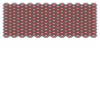

In [3]:
hex_grid